In [26]:
# no hace falta runearlo por ahora
# ! pip install textblob

In [27]:
import nltk
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('punt_tab')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re

# from textblob import TextBlob
from pathlib import Path
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import contractions
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk import pos_tag

In [28]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
# Initialize stemmer/lemmatizer (run once)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Load the dataset

In [29]:
base_path_alvaro = Path(r"C:\Users\Alvaro Millan Ruiz\OneDrive\Escritorio\BDS\Block_5\NLP\Project")
base_path_gilda = "/Users/szonjapike/Desktop/BDS/Block_5/NLP/TXT/"

base_path = base_path_alvaro # change according to user

In [30]:
# Load the dataset for sentiment analysis
df_sentiment = pd.read_csv(base_path / "df_sentiment_analysis.csv")
df_sentiment

,Session,Year,ISO-Code,Speech,number_sentences,number_tokens,Income Level,speeches_for_keyword_search,matched_climate_keywords,contains_climate_keyword,climate_sentences
0,45,1990,ATG,"﻿Please accept my country's congratulations, S...",115,3134,3,"please accept my country's congratulations, si...",['global warming'],True,['our oceans are polluted by various contamina...
1,45,1990,AUT,"﻿\n\nI am pleased, Sir, to congratulate you on...",162,4743,4,"i am pleased, sir, to congratulate you on your...","['carbon dioxide', 'emissions', 'greenhouse']",True,['one of the most urgent priority measures one...
2,45,1990,BFA,"﻿\nMr. President, events in Eastern and Centra...",91,2948,1,"mr. president, events in eastern and central e...","['carbon dioxide', 'greenhouse effect', 'green...",True,['we must urgently orient research towards tec...
3,45,1990,BGD,"﻿\nMr. President, warm felicitations are due y...",180,3107,1,"mr. president, warm felicitations are due you ...",['climate change'],True,['we hope the proposed conventions on climate ...
4,45,1990,COD,"﻿Mr. President, the forty-fifth session of the...",88,3865,1,"mr. president, the forty-fifth session of the ...","['climate change', 'carbon dioxide', 'greenhou...",True,['with a view to finding some grounds for unde...
...,...,...,...,...,...,...,...,...,...,...,...
3167,79,2024,WSM,"Excellencies, \nI extend my congratulations t...",68,1572,2,"excellencies, i extend my congratulations to h...","['climate change', 'climate action', 'extreme ...",True,['the effects of climate change are being live...
3168,79,2024,YEM,"Your Majesties, Excellencies, and Highnesses, ...",57,1876,1,"ladies and gentlemen, it is a happy coincidenc...",['climate change'],True,['this includes not only immediate humanitaria...
3169,79,2024,ZAF,President of the 79th Session of the UN Genera...,100,1870,3,president of the 79th session of the un genera...,"['climate change', 'climate action', 'emission...",True,"['extreme weather such as flooding, fires and ..."
3170,79,2024,ZMB,"\n YOUR EXCELLENCY PHILEMON YANG, PRESIDENT O...",81,2348,2,"ladies and gentlemen, i congratulate you, your...","['climate change', 'extreme weather']",True,"['mr. president, climate change and extreme we..."


# Initialize sentiment analysis setup

In [31]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()


In [32]:
def get_vader_scores(sent_list):
    if not isinstance(sent_list, list):
        return []
    return [sia.polarity_scores(sent)['compound'] for sent in sent_list if isinstance(sent, str)]

### First try with smaller dataset

In [33]:
df_sentiment_2010_2017 = df_sentiment[df_sentiment['Year'].between(2010, 2017)].copy()
df_sentiment_2010_2017

,Session,Year,ISO-Code,Speech,number_sentences,number_tokens,Income Level,speeches_for_keyword_search,matched_climate_keywords,contains_climate_keyword,climate_sentences
963,65,2010,AGO,"First, I should \nlike to take this opportunit...",55,1893,2,"first, i should like to take this opportunity ...",['climate change'],True,['25 10-55276 in the president’s speech to the...
964,65,2010,ALB,It is a \nspecial honour for me to address the...,75,2238,3,it is a special honour for me to address the s...,['climate change'],True,['the united nations challenging agenda must f...
965,65,2010,AND,It is certainly a great opportunity for the \...,68,1872,4,it is certainly a great opportunity for the pr...,"['climate change', 'framework convention on cl...",True,"['the struggle to combat climate change, howev..."
966,65,2010,ARE,"At the outset, I congratulate you, Sir, \non y...",50,1609,4,"at the outset, i congratulate you, sir, on you...","['climate change', 'framework convention on cl...",True,['as part of our efforts to strengthen interna...
967,65,2010,ARG,Most \nof the speeches we have heard so far to...,94,2907,3,most of the speeches we have heard so far toda...,"['climate change', 'global warming']",True,"['climate change has been another focus.', 'cl..."
...,...,...,...,...,...,...,...,...,...,...,...
2039,72,2017,VUT,It is a great honour for me to make this state...,104,2777,2,it is a great honour for me to make this state...,"['climate change', 'temperature', 'extreme wea...",True,['we know that the way ahead to implement this...
2040,72,2017,WSM,Samoa warmly welcomes the assumption of Mr. Mi...,101,2870,3,samoa warmly welcomes the assumption of mr. mi...,"['climate change', 'framework convention on cl...",True,"['climate change is an existential threat.', '..."
2041,72,2017,ZAF,I take this opportunity to express South Afric...,77,1989,3,i take this opportunity to express south afric...,['climate change'],True,['we take this opportunity to express our empa...
2042,72,2017,ZMB,Let me join previous speakers in congratulatin...,62,1716,2,let me join previous speakers in congratulatin...,"['climate change', 'framework convention on cl...",True,"['there is a need, therefore, to develop innov..."


In [34]:
import ast

# Fix stringified lists in the column
df_sentiment_2010_2017['climate_sentences'] = df_sentiment['climate_sentences'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


In [35]:
df_sentiment_2010_2017['vader_scores'] = df_sentiment_2010_2017['climate_sentences'].apply(get_vader_scores) 
df_sentiment_2010_2017



,Session,Year,ISO-Code,Speech,number_sentences,number_tokens,Income Level,speeches_for_keyword_search,matched_climate_keywords,contains_climate_keyword,climate_sentences,vader_scores
963,65,2010,AGO,"First, I should \nlike to take this opportunit...",55,1893,2,"first, i should like to take this opportunity ...",['climate change'],True,[25 10-55276 in the president’s speech to the ...,"[0.6808, -0.5106]"
964,65,2010,ALB,It is a \nspecial honour for me to address the...,75,2238,3,it is a special honour for me to address the s...,['climate change'],True,[the united nations challenging agenda must fo...,[-0.6597]
965,65,2010,AND,It is certainly a great opportunity for the \...,68,1872,4,it is certainly a great opportunity for the pr...,"['climate change', 'framework convention on cl...",True,"[the struggle to combat climate change, howeve...","[-0.5719, -0.7506, 0.7096, 0.8442, 0.34, 0.4215]"
966,65,2010,ARE,"At the outset, I congratulate you, Sir, \non y...",50,1609,4,"at the outset, i congratulate you, sir, on you...","['climate change', 'framework convention on cl...",True,[as part of our efforts to strengthen internat...,"[0.4062, 0.6808, 0.6486]"
967,65,2010,ARG,Most \nof the speeches we have heard so far to...,94,2907,3,most of the speeches we have heard so far toda...,"['climate change', 'global warming']",True,"[climate change has been another focus., clima...","[0.0, 0.2716, -0.0258]"
...,...,...,...,...,...,...,...,...,...,...,...,...
2039,72,2017,VUT,It is a great honour for me to make this state...,104,2777,2,it is a great honour for me to make this state...,"['climate change', 'temperature', 'extreme wea...",True,[we know that the way ahead to implement this ...,"[-0.6808, -0.7579, 0.0, -0.5423, 0.7184, 0.648..."
2040,72,2017,WSM,Samoa warmly welcomes the assumption of Mr. Mi...,101,2870,3,samoa warmly welcomes the assumption of mr. mi...,"['climate change', 'framework convention on cl...",True,"[climate change is an existential threat., lik...","[-0.5267, 0.4215, 0.0, 0.4939, 0.4019, 0.0, 0...."
2041,72,2017,ZAF,I take this opportunity to express South Afric...,77,1989,3,i take this opportunity to express south afric...,['climate change'],True,[we take this opportunity to express our empat...,"[-0.2846, -0.5423, 0.4939]"
2042,72,2017,ZMB,Let me join previous speakers in congratulatin...,62,1716,2,let me join previous speakers in congratulatin...,"['climate change', 'framework convention on cl...",True,"[there is a need, therefore, to develop innova...","[-0.6486, -0.5719, -0.7579, -0.6486, 0.8271, -..."


In [42]:
df_sentiment = df_sentiment_2010_2017.copy()

In [43]:
df_sentiment['vader_avg'] = df_sentiment['vader_scores'].apply(
    lambda scores: sum(scores)/len(scores) if scores else None
)

df_sentiment['vader_min'] = df_sentiment['vader_scores'].apply(
    lambda scores: min(scores) if scores else None
)

df_sentiment['vader_max'] = df_sentiment['vader_scores'].apply(
    lambda scores: max(scores) if scores else None
)

df_sentiment

,Session,Year,ISO-Code,Speech,number_sentences,number_tokens,Income Level,speeches_for_keyword_search,matched_climate_keywords,contains_climate_keyword,climate_sentences,vader_scores,vader_avg,vader_min,vader_max
963,65,2010,AGO,"First, I should \nlike to take this opportunit...",55,1893,2,"first, i should like to take this opportunity ...",['climate change'],True,[25 10-55276 in the president’s speech to the ...,"[0.6808, -0.5106]",0.085100,-0.5106,0.6808
964,65,2010,ALB,It is a \nspecial honour for me to address the...,75,2238,3,it is a special honour for me to address the s...,['climate change'],True,[the united nations challenging agenda must fo...,[-0.6597],-0.659700,-0.6597,-0.6597
965,65,2010,AND,It is certainly a great opportunity for the \...,68,1872,4,it is certainly a great opportunity for the pr...,"['climate change', 'framework convention on cl...",True,"[the struggle to combat climate change, howeve...","[-0.5719, -0.7506, 0.7096, 0.8442, 0.34, 0.4215]",0.165467,-0.7506,0.8442
966,65,2010,ARE,"At the outset, I congratulate you, Sir, \non y...",50,1609,4,"at the outset, i congratulate you, sir, on you...","['climate change', 'framework convention on cl...",True,[as part of our efforts to strengthen internat...,"[0.4062, 0.6808, 0.6486]",0.578533,0.4062,0.6808
967,65,2010,ARG,Most \nof the speeches we have heard so far to...,94,2907,3,most of the speeches we have heard so far toda...,"['climate change', 'global warming']",True,"[climate change has been another focus., clima...","[0.0, 0.2716, -0.0258]",0.081933,-0.0258,0.2716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,72,2017,VUT,It is a great honour for me to make this state...,104,2777,2,it is a great honour for me to make this state...,"['climate change', 'temperature', 'extreme wea...",True,[we know that the way ahead to implement this ...,"[-0.6808, -0.7579, 0.0, -0.5423, 0.7184, 0.648...",-0.022200,-0.7579,0.7184
2040,72,2017,WSM,Samoa warmly welcomes the assumption of Mr. Mi...,101,2870,3,samoa warmly welcomes the assumption of mr. mi...,"['climate change', 'framework convention on cl...",True,"[climate change is an existential threat., lik...","[-0.5267, 0.4215, 0.0, 0.4939, 0.4019, 0.0, 0....",0.205100,-0.7906,0.9460
2041,72,2017,ZAF,I take this opportunity to express South Afric...,77,1989,3,i take this opportunity to express south afric...,['climate change'],True,[we take this opportunity to express our empat...,"[-0.2846, -0.5423, 0.4939]",-0.111000,-0.5423,0.4939
2042,72,2017,ZMB,Let me join previous speakers in congratulatin...,62,1716,2,let me join previous speakers in congratulatin...,"['climate change', 'framework convention on cl...",True,"[there is a need, therefore, to develop innova...","[-0.6486, -0.5719, -0.7579, -0.6486, 0.8271, -...",-0.273813,-0.7579,0.8271


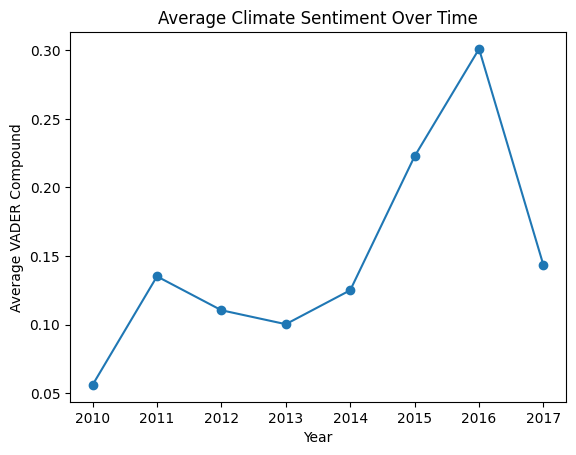

In [44]:
df_yearly = df_sentiment.groupby('Year')['vader_avg'].mean()
df_yearly.plot(kind='line', marker='o', title='Average Climate Sentiment Over Time')
plt.ylabel('Average VADER Compound')
plt.show()


<Axes: title={'center': 'Sentiment by Income Level'}, xlabel='Income Level'>

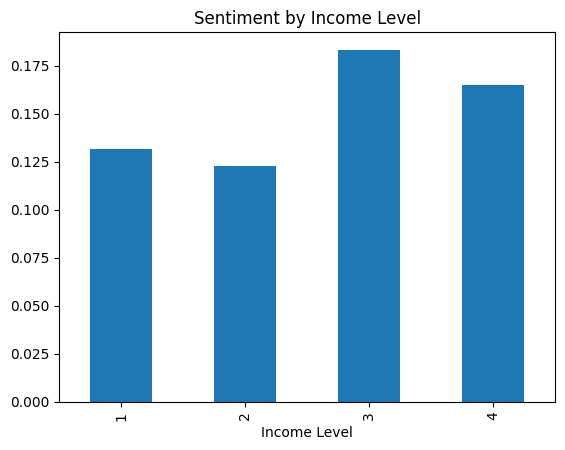

In [45]:
df_sentiment.groupby('Income Level')['vader_avg'].mean().plot.bar(title='Sentiment by Income Level')


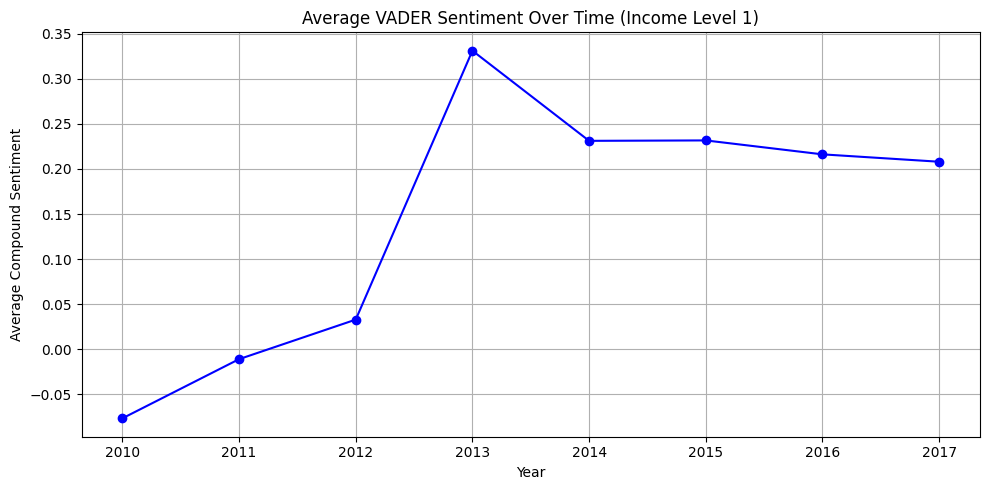

In [46]:
import matplotlib.pyplot as plt

# Filter for Income Level 1 only
df_income1 = df_sentiment[df_sentiment['Income Level'] == 1]

# Group by year and calculate mean vader_avg
avg_sentiment_by_year = df_income1.groupby('Year')['vader_avg'].mean().sort_index()

# Plot
plt.figure(figsize=(10, 5))
avg_sentiment_by_year.plot(marker='o', linestyle='-', color='blue')
plt.title('Average VADER Sentiment Over Time (Income Level 1)')
plt.xlabel('Year')
plt.ylabel('Average Compound Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
# Step 1: Get country-year average sentiment
country_year_avg = df_income1.groupby(['Year', 'ISO-Code'])['vader_avg'].mean().reset_index()
country_year_avg

,Year,ISO-Code,vader_avg
0,2010,BDI,-0.352300
1,2010,BEN,-0.332200
2,2010,BFA,0.282600
3,2010,BGD,0.227300
4,2010,CAF,0.493900
...,...,...,...
166,2017,TCD,0.897900
167,2017,TGO,0.500933
168,2017,TJK,0.030871
169,2017,TZA,-0.196914


In [52]:
# Step 2: Then average across countries per year
yearly_avg_sent = country_year_avg.groupby('Year')['vader_avg'].mean()

yearly_avg_sent

Year
2010   -0.076547
2011   -0.010927
2012    0.032941
2013    0.331119
2014    0.231177
2015    0.231646
2016    0.216192
2017    0.208008
Name: vader_avg, dtype: float64

In [53]:
country_counts = country_year_avg.groupby('Year')['ISO-Code'].nunique()
country_counts

Year
2010    26
2011    24
2012    16
2013    10
2014    20
2015    20
2016    27
2017    28
Name: ISO-Code, dtype: int64

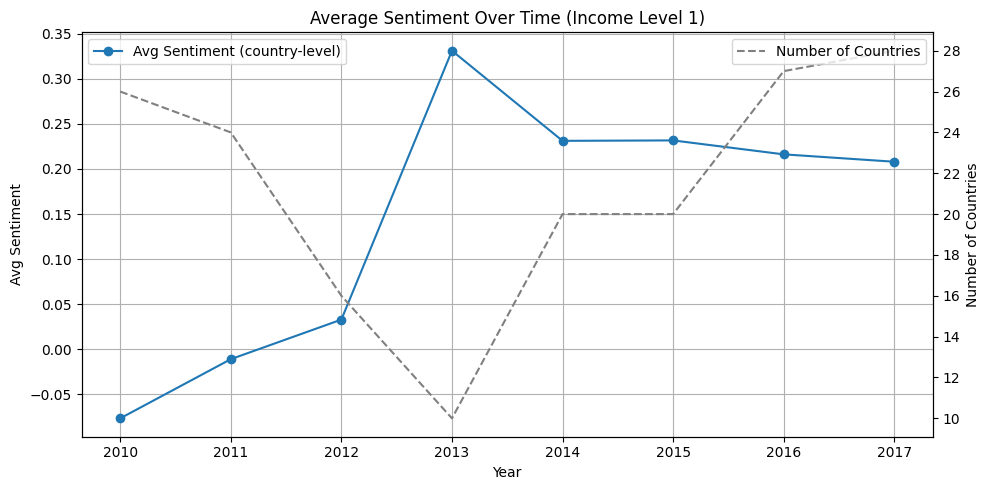

In [ ]:
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 5))

# Main plot: average sentiment
ax = yearly_avg_sent.plot(marker='o', label='Avg Sentiment (country-level)')

# Right axis: number of countries
ax2 = ax.twinx()
country_counts.plot(ax=ax2, secondary_y=False, style='--', color='gray', label='Number of Countries')

ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Labels and styling
ax.set_title('Average Sentiment Over Time (Income Level 1)')
ax.set_xlabel('Year')
ax.set_ylabel('Avg Sentiment')
ax2.set_ylabel('Number of Countries')
ax.grid(True)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()
